### 1. Imports, leitura do dataset e preparação
Nesta seção vamos:
- Ler o dataset de diabetes;
- Separar X (features) e y (rótulo Diabetes_012);
- Padronizar as variáveis;
- Criar uma amostra para métodos mais pesados (Agglomerative, DBSCAN, t-SNE, UMAP).


In [62]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import umap
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set()

# Leitura do dataset
print("Lendo dataset...")
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
print("Formato do dataset:", df.shape)

# Target e features
y = df["Diabetes_012"]
X = df.drop(columns=["Diabetes_012"])

# Padronização das features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("X_scaled:", X_scaled.shape)

# Amostra para métodos pesados
np.random.seed(42)
sample_size = 10000  # ajuste se ficar pesado (ex.: 5000)
sample_idx = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)

X_sample = X_scaled[sample_idx]
y_sample = y.iloc[sample_idx].values

print("Amostra criada:", X_sample.shape)


Lendo dataset...
Formato do dataset: (253680, 22)
X_scaled: (253680, 21)
Amostra criada: (10000, 21)


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

| Variável original        | Significado                                                |
| ------------------------ | ---------------------------------------------------------- |
| **Diabetes_012**         | Situação de Diabetes *(0=Não, 1=Pré-diabetes, 2=Diabetes)* |
| **HighBP**               | Pressão Alta                                               |
| **HighChol**             | Colesterol Alto                                            |
| **CholCheck**            | Fez Exame de Colesterol nos Últimos 5 Anos                 |
| **BMI**                  | Índice de Massa Corporal (IMC)                             |
| **Smoker**               | Fumante                                                    |
| **Stroke**               | Teve AVC                                                   |
| **HeartDiseaseorAttack** | Doença Cardíaca / Infarto                                  |
| **PhysActivity**         | Atividade Física (exceto trabalho)                         |
| **Fruits**               | Consumo de Frutas Diário                                   |
| **NoDocbcCost**          | Não Consultou Médico por Custo                             |
| **GenHlth**              | Saúde Geral (1=muito boa, 5=muito ruim)                    |
| **MentHlth**             | Dias de Saúde Mental Ruim                                  |
| **PhysHlth**             | Dias de Saúde Física Ruim                                  |
| **DiffWalk**             | Dificuldade para Caminhar                                  |
| **Sex**                  | Sexo (0=F, 1=M)                                            |
| **Age**                  | Faixa Etária                                               |
| **Education**            | Escolaridade                                               |
| **Income**               | Faixa de Renda                                             |


In [64]:
df.head()

Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0   
2          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0   
3          0.0      2.0       0.0       0.0       0.0  0.0  11.0        3.0   
4          0.0      2.0       3.0       0.0       0.0  0.0  11.0        5.0   

   Income  
0     3.0  
1     1.0  
2     8.0  
3     6.0  
4     4.0  

[5 rows x 22 columns]

In [65]:
df["Diabetes_012"].value_counts()


Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

### 2. Funções auxiliares
- plot_pca: plota PCA 2D com cores por rótulo/cluster
- plot_embedding: plota t-SNE/UMAP 2D
- resumo_clusters: calcula distribuição de Diabetes_012 por cluster
- comparar_silhouette: gera gráfico de barras com silhouette de cada método



In [66]:
def plot_pca_2d(X_pca, labels, title, label_name="Label"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=labels,
        palette="tab10",
        alpha=0.5
    )
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title=label_name)
    plt.tight_layout()
    plt.show()


def plot_embedding_2d(embedding, labels, title, label_name="Label"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette="tab10",
        alpha=0.6
    )
    plt.title(title)
    plt.xlabel("Dimensão 1")
    plt.ylabel("Dimensão 2")
    plt.legend(title=label_name)
    plt.tight_layout()
    plt.show()


def resumo_clusters(df_with_clusters, cluster_col="cluster", target_col="Diabetes_012"):
    """
    Retorna:
    - crosstab normalizada (proporção de cada classe de Diabetes_012 por cluster)
    - contagem total de pontos por cluster
    """
    freq = pd.crosstab(
        df_with_clusters[cluster_col],
        df_with_clusters[target_col],
        normalize="index"
    )
    counts = df_with_clusters[cluster_col].value_counts().sort_index()
    return freq, counts


def comparar_silhouette(resumo):
    """
    resumo: DataFrame com colunas ['Método', 'Silhouette']
    """
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=resumo,
        x="Método",
        y="Silhouette"
    )
    plt.xticks(rotation=20, ha="right")
    plt.title("Comparação do índice de Silhouette entre métodos de clusterização")
    plt.tight_layout()
    plt.show()


### 3. PCA (2D) – Visualização global dos dados
Vamos projetar o dataset completo em 2 dimensões com PCA e visualizar:
- cores por rótulo real (Diabetes_012)
- isso serve como "mapa base" para comparar com os clusters depois.



Variância explicada pelas 2 primeiras PCs: [0.16713006 0.08396704]  | soma = 0.2510970989889814


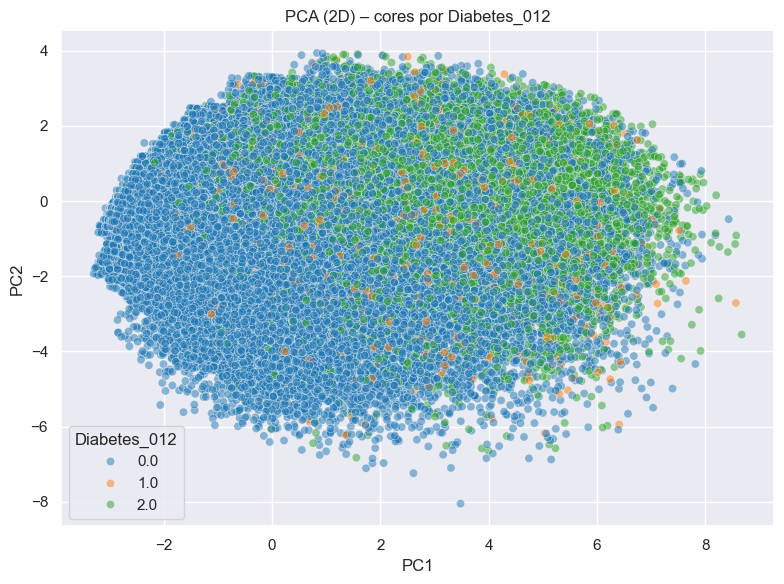

In [67]:
pca = PCA(n_components=2, random_state=42)
X_pca_full = pca.fit_transform(X_scaled)

var_ratio = pca.explained_variance_ratio_
print("Variância explicada pelas 2 primeiras PCs:", var_ratio, " | soma =", var_ratio.sum())

# PCA colorido pelo rótulo de Diabetes_012
plot_pca_2d(
    X_pca_full,
    y,
    title="PCA (2D) – cores por Diabetes_012",
    label_name="Diabetes_012"
)


### 4. K-Means
- Aplicado no dataset completo com k=4
- Calculamos silhouette
- Analisamos distribuição de Diabetes_012 por cluster
- Visualizamos clusters no espaço PCA



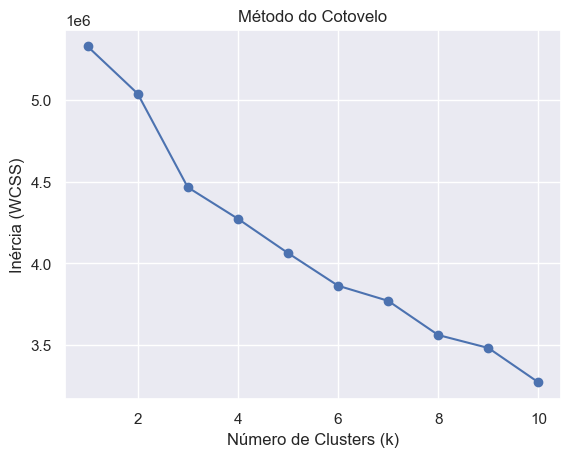

In [68]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.title('Método do Cotovelo')
plt.show()

Proporção de Diabetes_012 por cluster (K-Means):


Diabetes_012         0.0       1.0       2.0
cluster_kmeans                              
0               0.960912  0.007558  0.031531
1               0.870186  0.020235  0.109579
2               0.643325  0.031153  0.325522
3               0.778601  0.025679  0.195720

Tamanho de cada cluster (K-Means):


cluster_kmeans
0    112335
1     12256
2     40028
3     89061
Name: count, dtype: int64

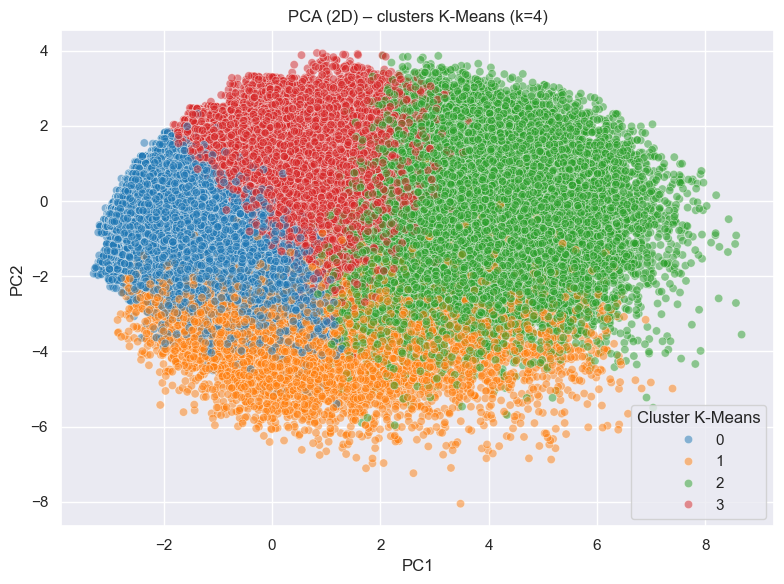

In [69]:
k = 4
kmeans_full = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_k_full = kmeans_full.fit_predict(X_scaled)

# sil_k_full = silhouette_score(X_scaled, labels_k_full)
# print("Silhouette K-Means (full, k=4):", sil_k_full)

# Adicionar clusters ao DataFrame
df_k = df.copy()
df_k["cluster_kmeans"] = labels_k_full

freq_k, counts_k = resumo_clusters(
    df_k,
    cluster_col="cluster_kmeans",
    target_col="Diabetes_012"
)

print("Proporção de Diabetes_012 por cluster (K-Means):")
display(freq_k)
print("Tamanho de cada cluster (K-Means):")
display(counts_k)

# Visualizar clusters no PCA
plot_pca_2d(
    X_pca_full,
    labels_k_full,
    title="PCA (2D) – clusters K-Means (k=4)",
    label_name="Cluster K-Means"
)


In [70]:
# Cálculo das médias de cada variável por cluster
cluster_profiles = df_k.groupby("cluster_kmeans").mean(numeric_only=True)

print("Médias das variáveis por cluster:")
display(cluster_profiles)


Médias das variáveis por cluster:


Diabetes_012    HighBP  HighChol  CholCheck        BMI  \
cluster_kmeans                                                           
0                   0.070619  0.072569  0.193261   0.944657  26.585695   
1                   0.239393  0.337141  0.325881   0.862598  28.860803   
2                   0.682197  0.679774  0.601254   0.982462  31.308784   
3                   0.417119  0.778511  0.649218   0.990265  29.267446   

                  Smoker    Stroke  HeartDiseaseorAttack  PhysActivity  \
cluster_kmeans                                                           
0               0.310313  0.005119              0.007406      0.881070   
1               0.491922  0.026436              0.062418      0.694680   
2               0.610098  0.153992              0.278705      0.452583   
3               0.529008  0.036256              0.125083      0.744602   

                  Fruits  ...  AnyHealthcare  NoDocbcCost   GenHlth  MentHlth  \
cluster_kmeans            ...                                                   
0               0.694441  ...       1.000000     0.053145  1.942431  2.038999   
1               0.569680  ...       0.000082     0.367901  2.677790  4.711896   
2               0.546617  ...       0.995953     0.187019  3.900670  9.810133   
3               0.606618  ...       1.000000     0.038053  2.581736  1.442079   

                 PhysHlth  DiffWalk       Sex       Age  Education    Income  
cluster_kmeans                                                                
0                1.360547  0.020225  0.403819  6.531277   5.415418  6.923497  
1                4.252529  0.145480  0.484334  6.139768   4.523499  4.634954  
2               17.856475  0.780878  0.354402  9.156366   4.479614  4.179449  
3                1.756279  0.082674  0.518981  9.680298   4.919134  5.994711  

[4 rows x 22 columns]

In [71]:
for col in df_k.select_dtypes(include=["object", "category"]).columns:
    print(f"\nProporção de {col} por cluster:")
    display(pd.crosstab(df_k[col], df_k["cluster_kmeans"], normalize='columns'))


In [72]:
cluster_diff = cluster_profiles.sub(df.mean(numeric_only=True))
display(cluster_diff)


Diabetes_012    HighBP  HighChol  CholCheck       BMI  \
cluster_kmeans                                                          
0                  -0.226302 -0.356432 -0.230860  -0.018013 -1.796669   
1                  -0.057528 -0.091860 -0.098240  -0.100072  0.478439   
2                   0.385276  0.250773  0.177133   0.019793  2.926420   
3                   0.120197  0.349510  0.225097   0.027596  0.885082   

                  Smoker    Stroke  HeartDiseaseorAttack  PhysActivity  \
cluster_kmeans                                                           
0              -0.132856 -0.035452             -0.086779      0.124526   
1               0.048754 -0.014135             -0.031767     -0.061864   
2               0.166929  0.113421              0.184519     -0.303960   
3               0.085840 -0.004315              0.030897     -0.011942   

                  Fruits  ...  AnyHealthcare  NoDocbcCost   GenHlth  MentHlth  \
cluster_kmeans            ...                                                   
0               0.060185  ...       0.048947    -0.031032 -0.568961 -1.145773   
1              -0.064576  ...      -0.950971     0.283725  0.166398  1.527124   
2              -0.087638  ...       0.044900     0.102842  1.389277  6.625361   
3              -0.027638  ...       0.048947    -0.046124  0.070344 -1.742693   

                 PhysHlth  DiffWalk       Sex       Age  Education    Income  
cluster_kmeans                                                                
0               -2.881534 -0.147999 -0.036523 -1.500842   0.364985  0.869622  
1                0.010449 -0.022744  0.043992 -1.892351  -0.526935 -1.418921  
2               13.614395  0.612655 -0.085940  1.124246  -0.570819 -1.874426  
3               -2.485801 -0.085550  0.078639  1.648179  -0.131300 -0.059163  

[4 rows x 22 columns]

In [73]:
from sklearn.feature_selection import f_classif
import pandas as pd

X = df_k.drop(columns=["cluster_kmeans"])
y = df_k["cluster_kmeans"]

f_vals, p_vals = f_classif(X, y)

importances = pd.DataFrame({
    "feature": X.columns,
    "F_value": f_vals,
    "p_value": p_vals
}).sort_values("F_value", ascending=False)

display(importances.head(10))



feature       F_value  p_value
12  AnyHealthcare  6.066393e+06      0.0
17       DiffWalk  8.840832e+04      0.0
16       PhysHlth  7.253545e+04      0.0
1          HighBP  6.832581e+04      0.0
14        GenHlth  5.521258e+04      0.0
19            Age  2.805021e+04      0.0
21         Income  2.529608e+04      0.0
2        HighChol  2.004642e+04      0.0
15       MentHlth  1.587670e+04      0.0
20      Education  1.304424e+04      0.0

### Comparação entre Grupos de Risco e os Diabéticos

In [74]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import pandas as pd

# Escolher o DF (K-Means)
df_temp = df_k.copy()

# 1. Selecionar variáveis numéricas (retirando alvo e cluster)
variaveis = df_temp.columns.drop(["Diabetes_012", "cluster_kmeans"])

# 2. Padronizar dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_temp[variaveis])
df_scaled = pd.DataFrame(X_scaled, columns=variaveis, index=df_temp.index)

# 3. Recolocar colunas importantes
df_scaled["Diabetes_012"] = df_temp["Diabetes_012"]
df_scaled["cluster_kmeans"] = df_temp["cluster_kmeans"]

# 4. Centroide dos diabéticos tipo 2
centroide_diabeticos = df_scaled[df_scaled["Diabetes_012"] == 2][variaveis].mean()

# 5. Distância dos clusters até o centroide dos diabéticos
resultados = {}
for cluster_id in sorted(df_scaled["cluster_kmeans"].unique()):
    centroide_cluster = df_scaled[df_scaled["cluster_kmeans"] == cluster_id][variaveis].mean()
    distancia = euclidean(centroide_cluster, centroide_diabeticos)
    resultados[cluster_id] = distancia

# 6. Resultado final
print("\nDistância Euclidiana (clusters K-Means → diabéticos):")
for c, d in resultados.items():
    print(f"Cluster {c}: {d:.2f}")



Distância Euclidiana (clusters K-Means → diabéticos):
Cluster 0: 3.20
Cluster 1: 5.02
Cluster 2: 2.06
Cluster 3: 1.57


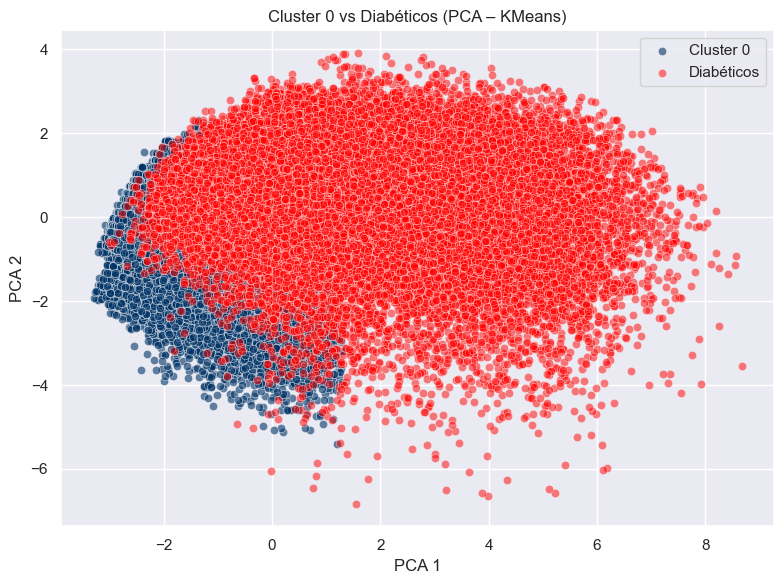

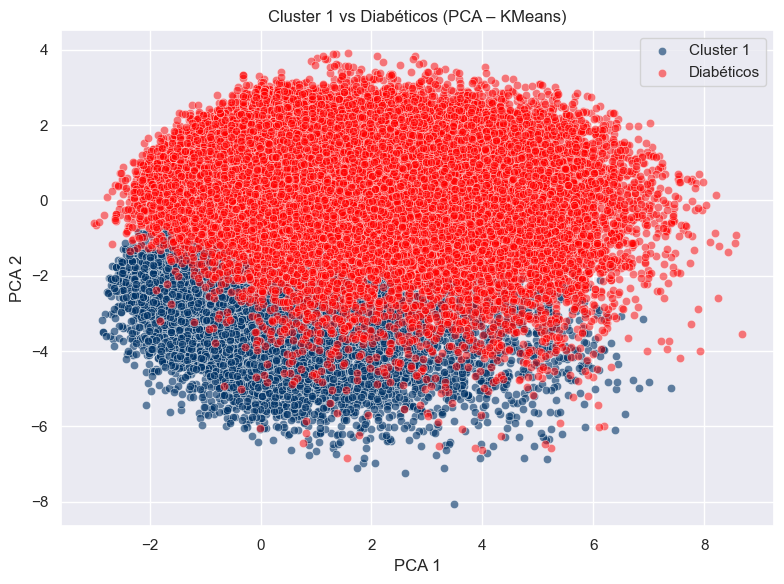

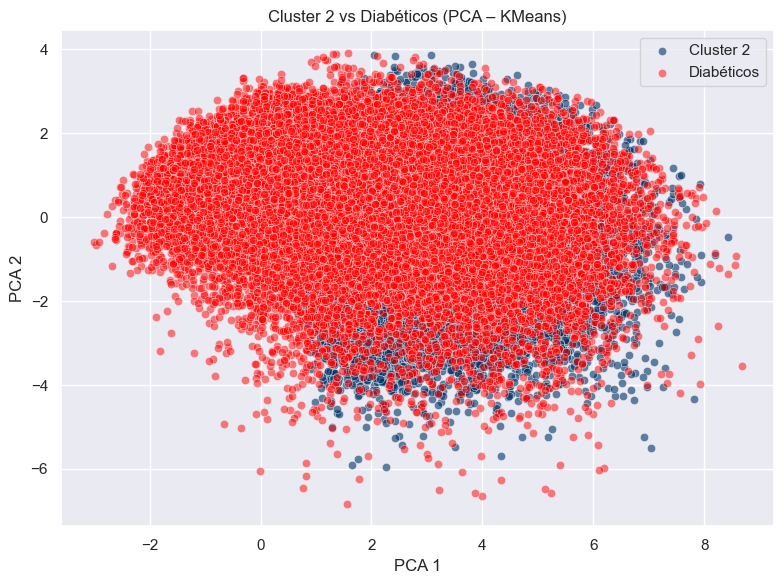

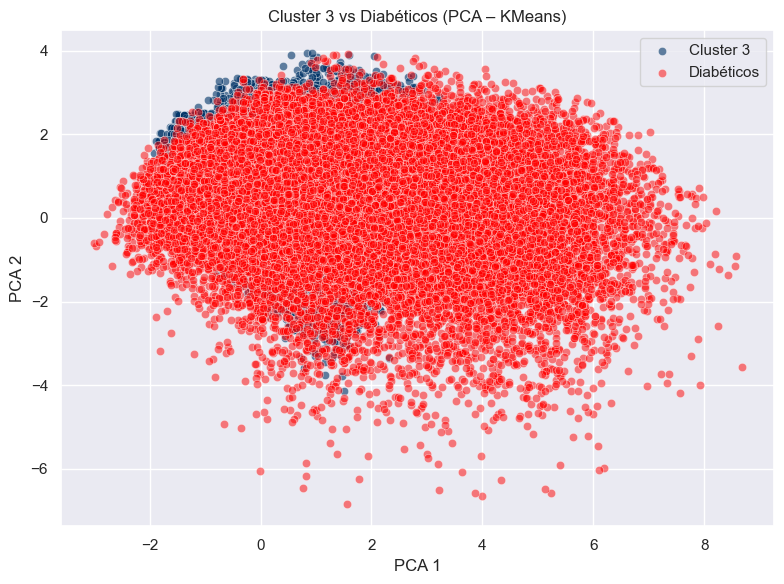

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === 1. Escolher o DF que já contém cluster_kmeans
df_temp = df_k.copy()

# === 2. Selecionar variáveis numéricas (todas exceto Diabetes e cluster)
variaveis = df_temp.columns.drop(["Diabetes_012", "cluster_kmeans"])

# === 3. Padronizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_temp[variaveis])

# === 4. PCA em 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === 5. Criar DF com PCA
df_pca = df_temp.copy()
df_pca["PCA1"] = X_pca[:, 0]
df_pca["PCA2"] = X_pca[:, 1]

# === 6. Filtrar diabéticos tipo 2
diabeticos = df_pca[df_pca["Diabetes_012"] == 2]

# === 7. Plotar cada cluster separado contra os diabéticos
for cluster_id in sorted(df_pca["cluster_kmeans"].unique()):
    cluster = df_pca[
        (df_pca["cluster_kmeans"] == cluster_id) &
        (df_pca["Diabetes_012"] == 0)  # compara cluster vs diabéticos
    ]

    plt.figure(figsize=(8, 6))

    # Cluster KMeans
    sns.scatterplot(
        data=cluster,
        x="PCA1",
        y="PCA2",
        label=f"Cluster {cluster_id}",
        alpha=0.6,
        color="#003366"     # azul escuro
    )

    # Diabéticos tipo 2
    sns.scatterplot(
        data=diabeticos,
        x="PCA1",
        y="PCA2",
        label="Diabéticos",
        alpha=0.5,
        color="red"
    )

    plt.title(f"Cluster {cluster_id} vs Diabéticos (PCA – KMeans)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


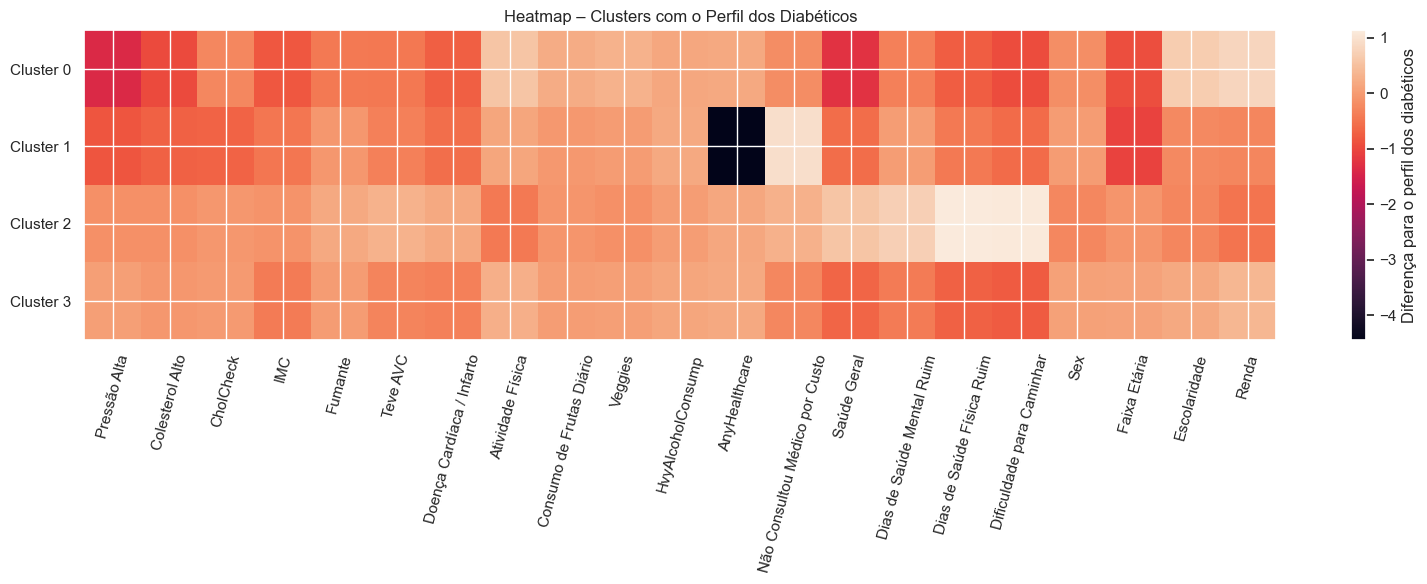

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dicionário de tradução
traducao = {
    "Diabetes_012": "Situação de Diabetes",
    "HighBP": "Pressão Alta",
    "HighChol": "Colesterol Alto",
    "BMI": "IMC",
    "Smoker": "Fumante",
    "Stroke": "Teve AVC",
    "HeartDiseaseorAttack": "Doença Cardíaca / Infarto",
    "PhysActivity": "Atividade Física",
    "Fruits": "Consumo de Frutas Diário",
    "NoDocbcCost": "Não Consultou Médico por Custo",
    "GenHlth": "Saúde Geral",
    "MentHlth": "Dias de Saúde Mental Ruim",
    "PhysHlth": "Dias de Saúde Física Ruim",
    "DiffWalk": "Dificuldade para Caminhar",
    "Age": "Faixa Etária",
    "Education": "Escolaridade",
    "Income": "Renda"
}

# 1. Variáveis numéricas (remove alvo e cluster)
variaveis = df_scaled.columns.drop(["Diabetes_012", "cluster_kmeans"])

# 2. Centroide dos diabéticos tipo 2
centroide_diabeticos = df_scaled[df_scaled["Diabetes_012"] == 2][variaveis].mean()

# 3. Centróides dos clusters
cluster_centroids = df_scaled.groupby("cluster_kmeans")[variaveis].mean()

# 4. Diferença cluster - diabéticos (quanto menor, mais parecido)
diff = cluster_centroids.subtract(centroide_diabeticos, axis=1)

# 5. Renomear variáveis para português
diff_pt = diff.rename(columns=traducao)

# 6. Plot Heatmap
plt.figure(figsize=(16, 6))
plt.imshow(diff_pt.values, aspect="auto")
plt.colorbar(label="Diferença para o perfil dos diabéticos")

plt.xticks(
    ticks=np.arange(len(diff_pt.columns)),
    labels=diff_pt.columns,
    rotation=75
)

plt.yticks(
    ticks=np.arange(len(diff_pt.index)),
    labels=[f"Cluster {c}" for c in diff_pt.index]
)

plt.title("Heatmap – Clusters com o Perfil dos Diabéticos")
plt.tight_layout()
plt.show()


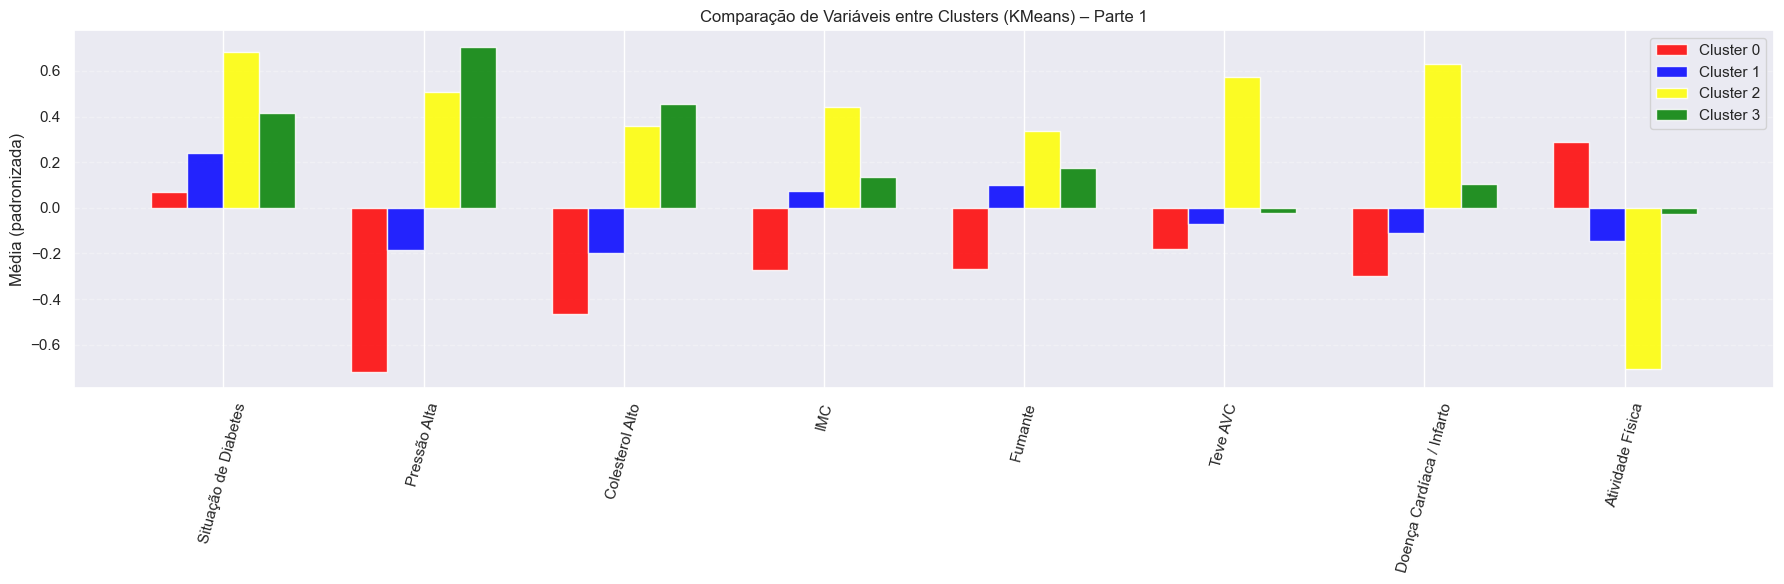

C:\Users\bcbru\AppData\Local\Temp\ipykernel_15156\2243481154.py:90: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



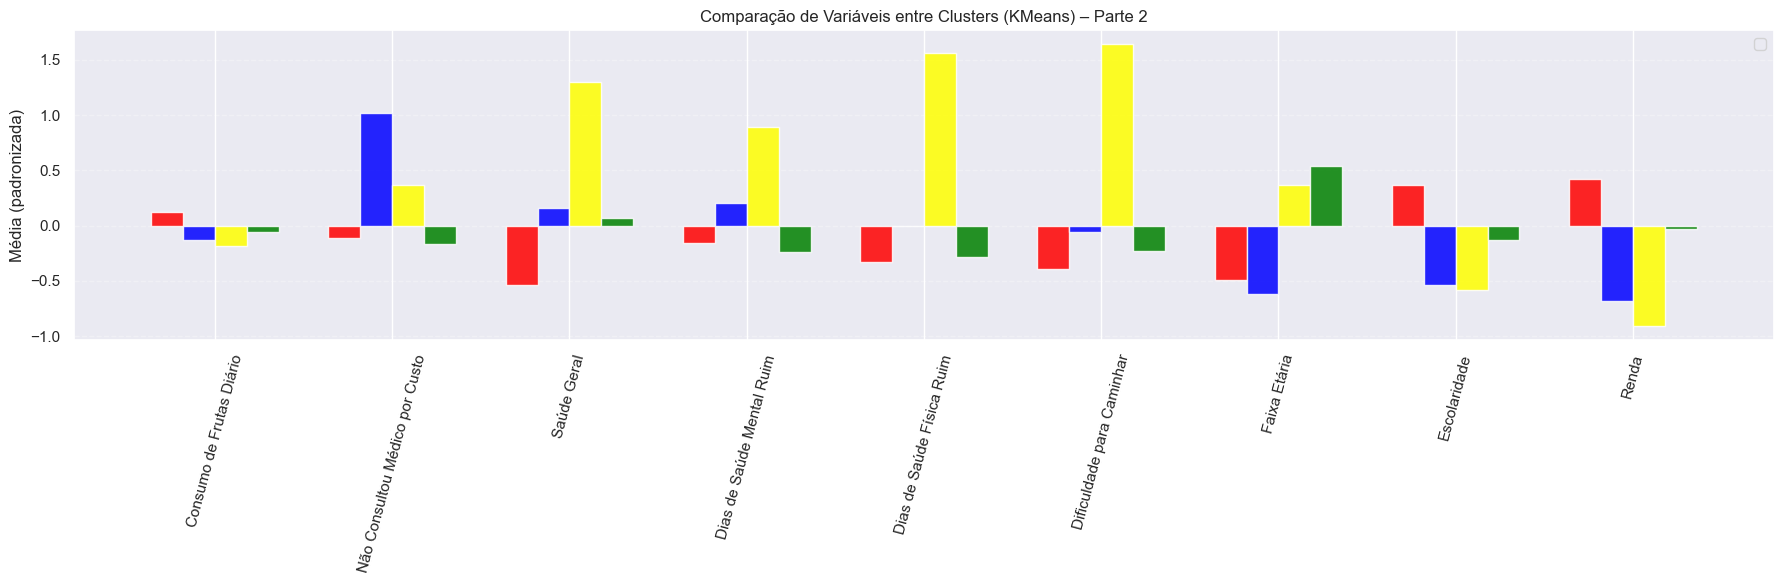

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Tradução das variáveis
traducao = {
    "Diabetes_012": "Situação de Diabetes",
    "HighBP": "Pressão Alta",
    "HighChol": "Colesterol Alto",
    "BMI": "IMC",
    "Smoker": "Fumante",
    "Stroke": "Teve AVC",
    "HeartDiseaseorAttack": "Doença Cardíaca / Infarto",
    "PhysActivity": "Atividade Física",
    "Fruits": "Consumo de Frutas Diário",
    "NoDocbcCost": "Não Consultou Médico por Custo",
    "GenHlth": "Saúde Geral",
    "MentHlth": "Dias de Saúde Mental Ruim",
    "PhysHlth": "Dias de Saúde Física Ruim",
    "DiffWalk": "Dificuldade para Caminhar",
    "Age": "Faixa Etária",
    "Education": "Escolaridade",
    "Income": "Renda"
}

# Lista original de variáveis
variaveis = list(traducao.keys())

# Agrupar por cluster
proporcoes = df_scaled.groupby("cluster_kmeans")[variaveis].mean()

# Traduzir para português
proporcoes = proporcoes.rename(columns=traducao)

# Separar automaticamente em dois grupos
cols = proporcoes.columns.tolist()
meio = len(cols) // 2
cols_1 = cols[:meio]
cols_2 = cols[meio:]

clusters = proporcoes.index
n_clusters = len(clusters)
cores = ["red", "blue", "yellow", "green"]
largura = 0.18

# ----------------------------
# GRÁFICO 1
# ----------------------------
plt.figure(figsize=(18, 6))

x1 = np.arange(len(cols_1))

for i, cluster in enumerate(clusters):
    plt.bar(
        x1 + i*largura,
        proporcoes.loc[cluster, cols_1],
        width=largura,
        label=f"Cluster {cluster}",
        color=cores[i],
        alpha=0.85
    )

plt.xticks(x1 + largura*(n_clusters-1)/2, cols_1, rotation=75)
plt.ylabel("Média (padronizada)")
plt.title("Comparação de Variáveis entre Clusters (KMeans) – Parte 1")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# GRÁFICO 2
# ----------------------------
plt.figure(figsize=(18, 6))

x2 = np.arange(len(cols_2))

for i, cluster in enumerate(clusters):
    plt.bar(
        x2 + i*largura,
        proporcoes.loc[cluster, cols_2],
        width=largura,
        color=cores[i],
        alpha=0.85
    )

plt.xticks(x2 + largura*(n_clusters-1)/2, cols_2, rotation=75)
plt.ylabel("Média (padronizada)")
plt.title("Comparação de Variáveis entre Clusters (KMeans) – Parte 2")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


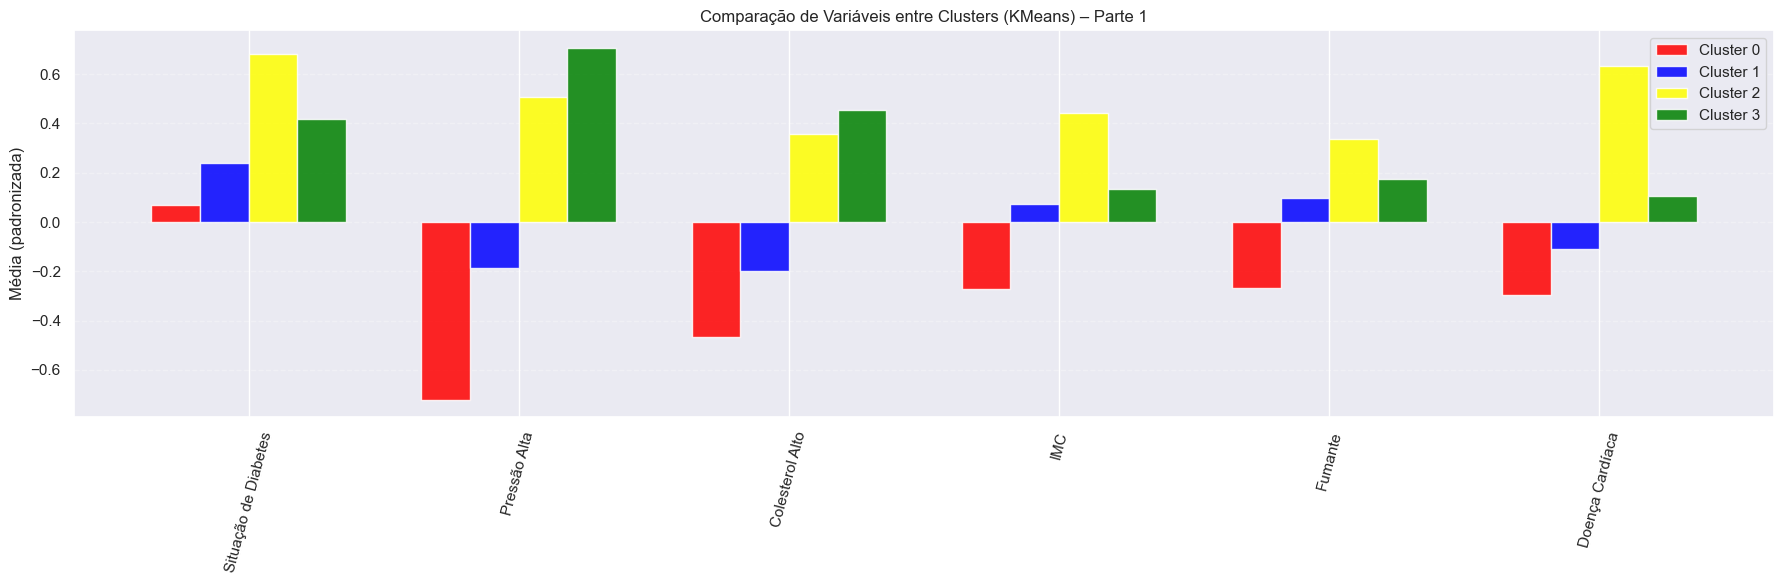

C:\Users\bcbru\AppData\Local\Temp\ipykernel_15156\2788471258.py:85: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



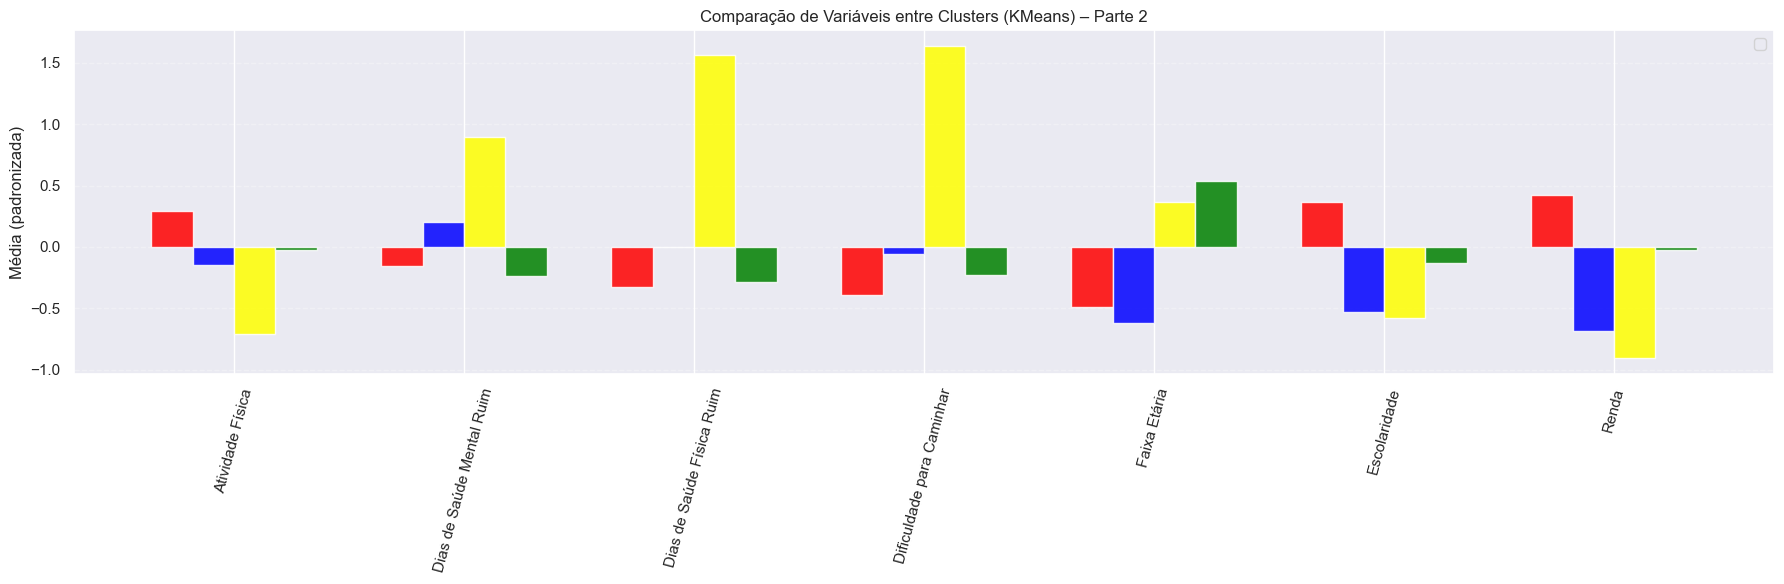

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Tradução das variáveis
traducao = {
    "Diabetes_012": "Situação de Diabetes",
    "HighBP": "Pressão Alta",
    "HighChol": "Colesterol Alto",
    "BMI": "IMC",
    "Smoker": "Fumante",
    "HeartDiseaseorAttack": "Doença Cardíaca",
    "PhysActivity": "Atividade Física",
    "MentHlth": "Dias de Saúde Mental Ruim",
    "PhysHlth": "Dias de Saúde Física Ruim",
    "DiffWalk": "Dificuldade para Caminhar",
    "Age": "Faixa Etária",
    "Education": "Escolaridade",
    "Income": "Renda"
}
# Lista original de variáveis
variaveis = list(traducao.keys())

# Agrupar por cluster
proporcoes = df_scaled.groupby("cluster_kmeans")[variaveis].mean()

# Traduzir para português
proporcoes = proporcoes.rename(columns=traducao)

# Separar automaticamente em dois grupos
cols = proporcoes.columns.tolist()
meio = len(cols) // 2
cols_1 = cols[:meio]
cols_2 = cols[meio:]

clusters = proporcoes.index
n_clusters = len(clusters)
cores = ["red", "blue", "yellow", "green"]
largura = 0.18

# ----------------------------
# GRÁFICO 1
# ----------------------------
plt.figure(figsize=(18, 6))

x1 = np.arange(len(cols_1))

for i, cluster in enumerate(clusters):
    plt.bar(
        x1 + i*largura,
        proporcoes.loc[cluster, cols_1],
        width=largura,
        label=f"Cluster {cluster}",
        color=cores[i],
        alpha=0.85
    )

plt.xticks(x1 + largura*(n_clusters-1)/2, cols_1, rotation=75)
plt.ylabel("Média (padronizada)")
plt.title("Comparação de Variáveis entre Clusters (KMeans) – Parte 1")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# GRÁFICO 2
# ----------------------------
plt.figure(figsize=(18, 6))

x2 = np.arange(len(cols_2))

for i, cluster in enumerate(clusters):
    plt.bar(
        x2 + i*largura,
        proporcoes.loc[cluster, cols_2],
        width=largura,
        color=cores[i],
        alpha=0.85
    )

plt.xticks(x2 + largura*(n_clusters-1)/2, cols_2, rotation=75)
plt.ylabel("Média (padronizada)")
plt.title("Comparação de Variáveis entre Clusters (KMeans) – Parte 2")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


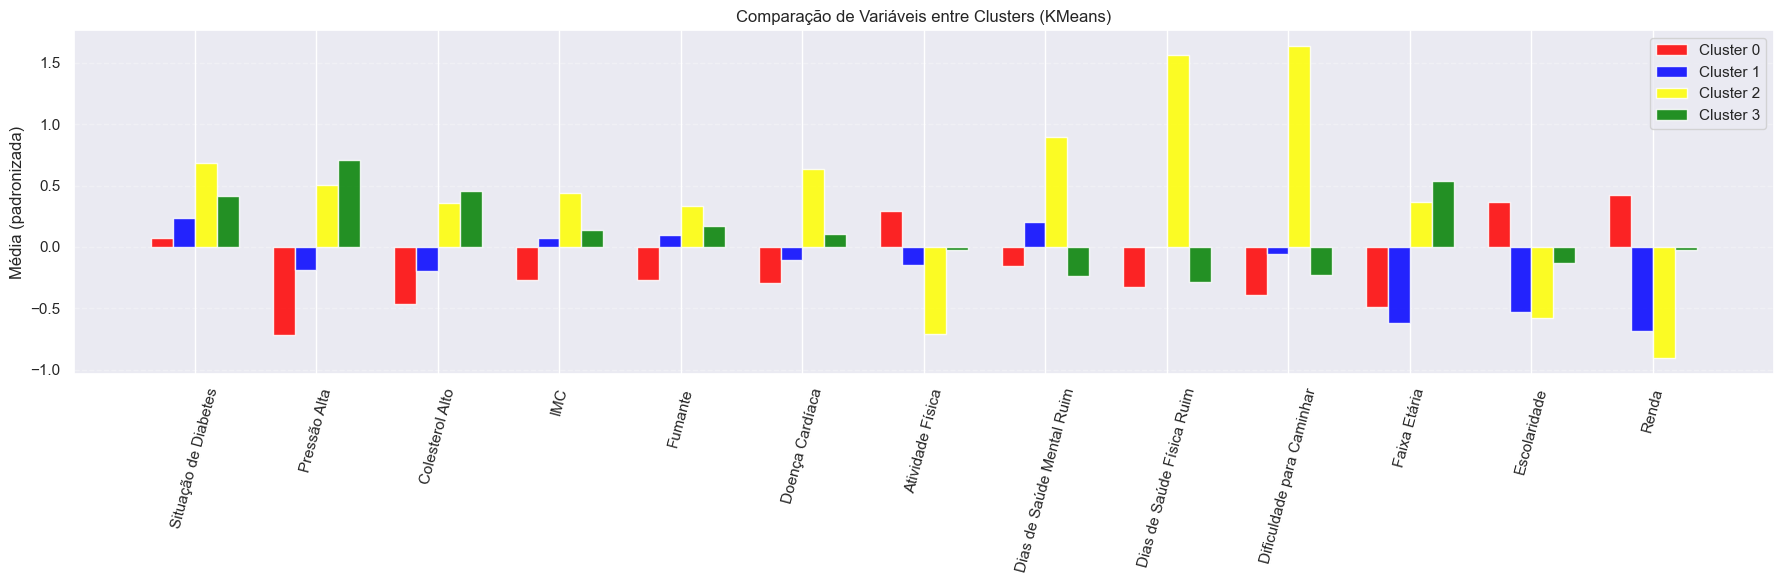

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Lista das variáveis que você quer comparar
variaveis = proporcoes.columns   # usa todas as 22
# ou selecione manualmente uma parte
# variaveis = ["Diabetes_012","HighBP","HighChol","BMI","Smoker","Stroke"]

clusters = proporcoes.index
n_clusters = len(clusters)

# Posição base das barras
x = np.arange(len(variaveis))
largura = 0.18

# Paleta para os 4 clusters
cores = ["red", "blue", "yellow", "green"]

plt.figure(figsize=(18,6))

for i, cluster in enumerate(clusters):
    plt.bar(
        x + i*largura,
        proporcoes.loc[cluster],
        width=largura,
        label=f"Cluster {cluster}",
        color=cores[i],
        alpha=0.85
    )

plt.xticks(x + largura*(n_clusters-1)/2, variaveis, rotation=75)
plt.ylabel("Média (padronizada)")
plt.title("Comparação de Variáveis entre Clusters (KMeans)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


### 5. Agglomerative Clustering (amostra)
- Aplicado em uma amostra de 10.000 pontos
- Silhouette, distribuição de Diabetes_012 por cluster
- Visualização no PCA (mesma amostra)



Silhouette Agglomerative (amostra 10k, k=4): 0.1699921892706812
Proporção de Diabetes_012 por cluster (Agglomerative):


Diabetes_012       0.0       1.0       2.0
cluster_agg                               
0             0.890497  0.015401  0.094101
1             0.728021  0.026851  0.245128
2             0.913486  0.015267  0.071247
3             0.677184  0.014563  0.308252

Tamanho de cada cluster (Agglomerative):


cluster_agg
0    6493
1    2309
2     786
3     412
Name: count, dtype: int64

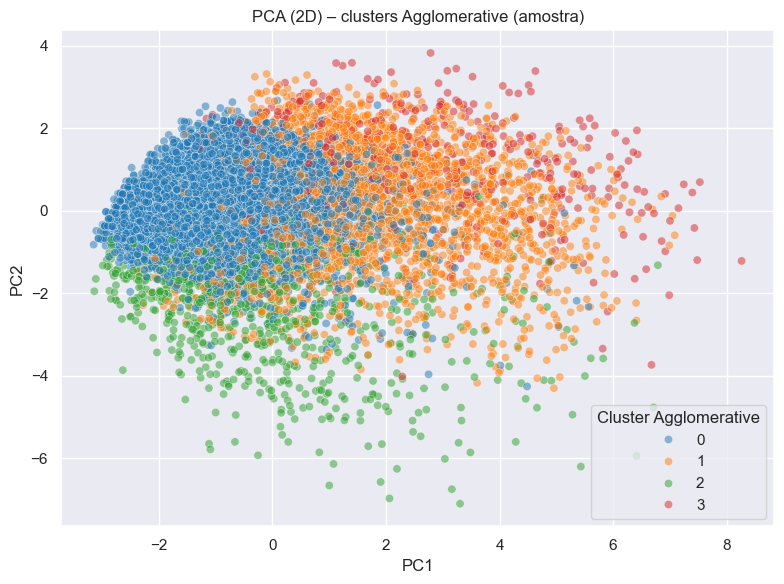

In [80]:
agg = AgglomerativeClustering(n_clusters=4)
labels_agg = agg.fit_predict(X_sample)

sil_agg = silhouette_score(X_sample, labels_agg)
print("Silhouette Agglomerative (amostra 10k, k=4):", sil_agg)

df_agg = df.iloc[sample_idx].copy()
df_agg["cluster_agg"] = labels_agg

freq_agg, counts_agg = resumo_clusters(
    df_agg,
    cluster_col="cluster_agg",
    target_col="Diabetes_012"
)

print("Proporção de Diabetes_012 por cluster (Agglomerative):")
display(freq_agg)
print("Tamanho de cada cluster (Agglomerative):")
display(counts_agg)

# PCA na amostra (reusando o PCA treinado no full)
X_pca_sample = X_pca_full[sample_idx]

plot_pca_2d(
    X_pca_sample,
    labels_agg,
    title="PCA (2D) – clusters Agglomerative (amostra)",
    label_name="Cluster Agglomerative"
)


### 6. DBSCAN (amostra)
- Algoritmo baseado em densidade
- Gera clusters + pontos de ruído (-1)
- Calculamos silhouette apenas para pontos não-ruído
- Analisamos distribuição de Diabetes_012 por cluster


Clusters DBSCAN (label: tamanho):
{np.int64(-1): np.int64(8656), np.int64(0): np.int64(595), np.int64(1): np.int64(301), np.int64(2): np.int64(160), np.int64(3): np.int64(85), np.int64(4): np.int64(112), np.int64(5): np.int64(91)}
Silhouette DBSCAN (sem ruído): 0.3198402008920358
Proporção de Diabetes_012 por cluster (DBSCAN – incluindo ruído -1):


Diabetes_012         0.0       1.0       2.0
cluster_dbscan                              
-1              0.826017  0.019755  0.154228
 0              0.976471  0.006723  0.016807
 1              0.990033  0.003322  0.006645
 2              0.993750  0.000000  0.006250
 3              0.917647  0.023529  0.058824
 4              0.973214  0.008929  0.017857
 5              0.934066  0.010989  0.054945

Tamanho de cada label (DBSCAN):


cluster_dbscan
-1    8656
 0     595
 1     301
 2     160
 3      85
 4     112
 5      91
Name: count, dtype: int64

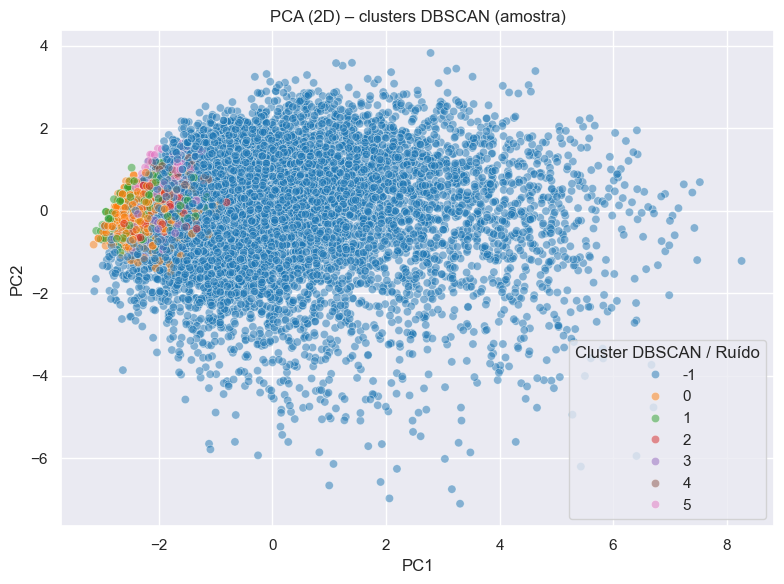

In [81]:
dbscan = DBSCAN(eps=1.4, min_samples=60)
labels_db = dbscan.fit_predict(X_sample)

unique_db, counts_db = np.unique(labels_db, return_counts=True)
print("Clusters DBSCAN (label: tamanho):")
print(dict(zip(unique_db, counts_db)))

mask_core = labels_db != -1

if mask_core.sum() > 0 and len(np.unique(labels_db[mask_core])) > 1:
    sil_db = silhouette_score(X_sample[mask_core], labels_db[mask_core])
    print("Silhouette DBSCAN (sem ruído):", sil_db)
else:
    sil_db = np.nan
    print("Não foi possível calcular silhouette (apenas ruído ou 1 cluster).")

df_db = df.iloc[sample_idx].copy()
df_db["cluster_dbscan"] = labels_db

freq_db, counts_db2 = resumo_clusters(
    df_db,
    cluster_col="cluster_dbscan",
    target_col="Diabetes_012"
)

print("Proporção de Diabetes_012 por cluster (DBSCAN – incluindo ruído -1):")
display(freq_db)
print("Tamanho de cada label (DBSCAN):")
display(counts_db2)

# Visualização no PCA (amostra)
plot_pca_2d(
    X_pca_sample,
    labels_db,
    title="PCA (2D) – clusters DBSCAN (amostra)",
    label_name="Cluster DBSCAN / Ruído"
)


In [82]:
cluster_profiles_db = df_db.groupby("cluster_dbscan").mean(numeric_only=True)
display(cluster_profiles_db)


Diabetes_012   HighBP  HighChol  CholCheck        BMI  \
cluster_dbscan                                                          
-1                  0.328212  0.49457  0.465573   0.957371  28.892907   
 0                  0.040336  0.00000  0.000000   1.000000  24.890756   
 1                  0.016611  0.00000  0.000000   1.000000  26.598007   
 2                  0.012500  0.00000  0.000000   1.000000  24.418750   
 3                  0.141176  0.00000  0.000000   1.000000  27.152941   
 4                  0.044643  0.00000  1.000000   1.000000  26.017857   
 5                  0.120879  0.00000  1.000000   1.000000  27.098901   

                  Smoker    Stroke  HeartDiseaseorAttack  PhysActivity  \
cluster_dbscan                                                           
-1              0.495726  0.048059              0.109057      0.721696   
 0              0.000000  0.000000              0.000000      1.000000   
 1              0.000000  0.000000              0.000000      1.000000   
 2              1.000000  0.000000              0.000000      1.000000   
 3              0.000000  0.000000              0.000000      1.000000   
 4              0.000000  0.000000              0.000000      1.000000   
 5              0.000000  0.000000              0.000000      1.000000   

                  Fruits  ...  AnyHealthcare  NoDocbcCost   GenHlth  MentHlth  \
cluster_dbscan            ...                                                   
-1              0.591728  ...       0.943392     0.100393  2.636437  3.579251   
 0              1.000000  ...       1.000000     0.000000  1.668908  0.831933   
 1              1.000000  ...       1.000000     0.000000  1.707641  0.571429   
 2              1.000000  ...       1.000000     0.000000  1.656250  0.531250   
 3              0.000000  ...       1.000000     0.000000  1.823529  0.270588   
 4              1.000000  ...       1.000000     0.000000  1.750000  0.401786   
 5              1.000000  ...       1.000000     0.000000  1.890110  0.472527   

                PhysHlth  DiffWalk       Sex       Age  Education    Income  
cluster_dbscan                                                               
-1              4.817006  0.193276  0.462223  8.216266   4.945587  5.851779  
 0              0.623529  0.000000  0.000000  6.364706   5.690756  7.410084  
 1              0.385382  0.000000  1.000000  6.504983   5.767442  7.627907  
 2              0.700000  0.000000  0.000000  7.481250   5.493750  7.525000  
 3              0.788235  0.000000  1.000000  5.658824   5.870588  7.705882  
 4              0.741071  0.000000  0.000000  8.330357   5.785714  7.482143  
 5              0.549451  0.000000  1.000000  7.681319   5.890110  7.813187  

[7 rows x 22 columns]

In [83]:
df_temp = df_db.copy()

# 1. Remover variáveis categóricas e a coluna de cluster
variaveis = df_temp.columns.drop(["Diabetes_012", "cluster_dbscan"])

# 2. Padronizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_temp[variaveis])
df_scaled = pd.DataFrame(X_scaled, columns=variaveis, index=df_temp.index)

# 3. Reconectar variáveis
df_scaled["Diabetes_012"] = df_temp["Diabetes_012"]
df_scaled["cluster_dbscan"] = df_temp["cluster_dbscan"]

# 4. Centroide diabéticos tipo 2
centroide_diabeticos = df_scaled[df_scaled["Diabetes_012"] == 2][variaveis].mean()

# 5. Distância de cada cluster ao centroide dos diabéticos
resultados = {}
for cluster_id in sorted(df_scaled["cluster_dbscan"].unique()):
    centroide_cluster = df_scaled[df_scaled["cluster_dbscan"] == cluster_id][variaveis].mean()
    distancia = euclidean(centroide_cluster, centroide_diabeticos)
    resultados[cluster_id] = distancia

# 6. Mostrar
print("\nDistância Euclidiana (clusters DBSCAN → diabéticos):")
for c, d in resultados.items():
    print(f"Cluster {c}: {d:.2f}")



Distância Euclidiana (clusters DBSCAN → diabéticos):
Cluster -1: 1.47
Cluster 0: 4.26
Cluster 1: 4.25
Cluster 2: 4.17
Cluster 3: 4.35
Cluster 4: 3.92
Cluster 5: 3.96


### 7. t-SNE e UMAP – Visualização de estruturas em 2D
Vamos:
- Rodar t-SNE e UMAP na amostra;
- Visualizar colorindo por rótulo real (Diabetes_012);
- Visualizar colorindo pelos clusters K-Means (amostra).


Rodando t-SNE na amostra...
t-SNE concluído: (10000, 2)


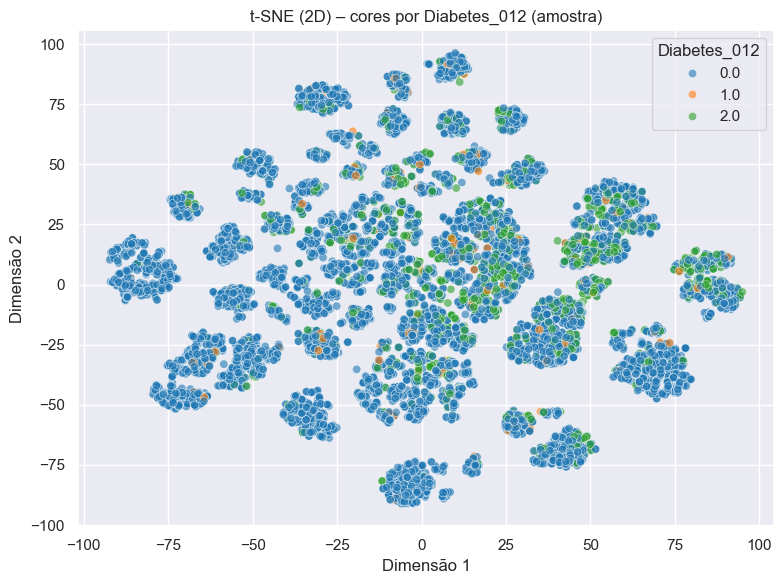

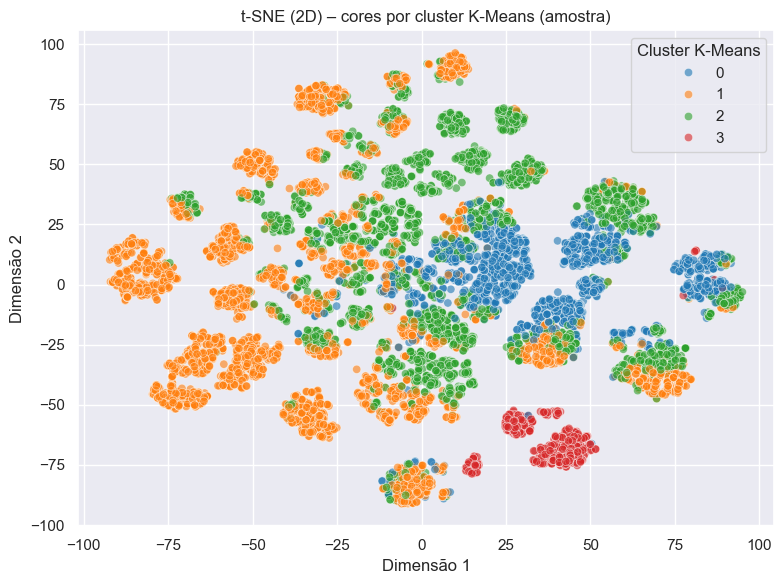

Rodando UMAP na amostra...


c:\diabetes-unsupervised-learning\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP concluído: (10000, 2)


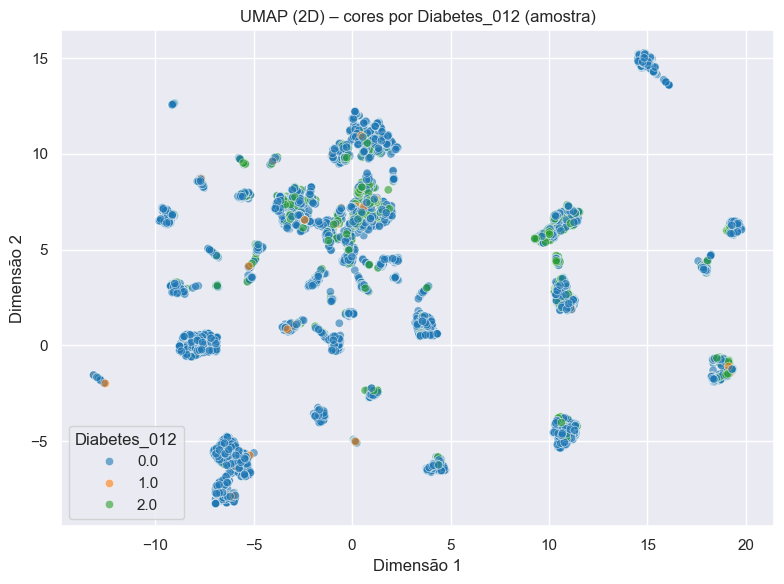

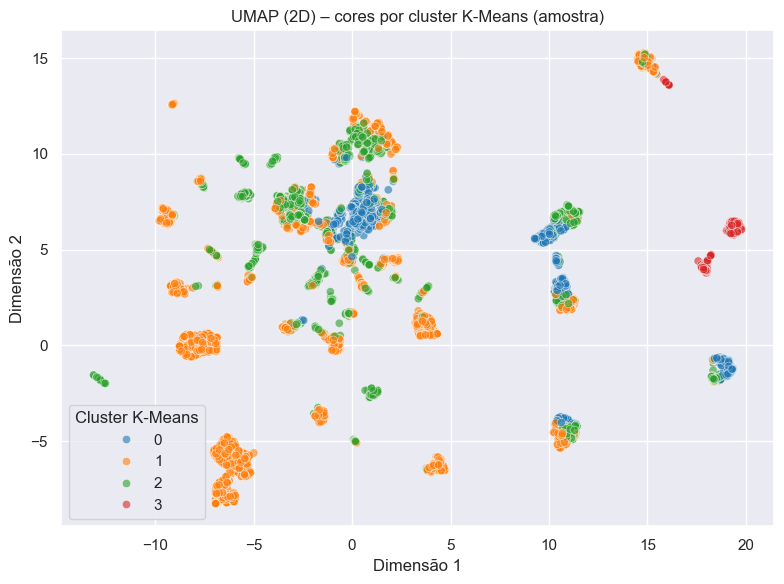

In [84]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)

print("Rodando t-SNE na amostra...")
X_tsne = tsne.fit_transform(X_sample)
print("t-SNE concluído:", X_tsne.shape)

# t-SNE por rótulo verdadeiro
plot_embedding_2d(
    X_tsne,
    y_sample,
    title="t-SNE (2D) – cores por Diabetes_012 (amostra)",
    label_name="Diabetes_012"
)

# t-SNE por clusters K-Means (na amostra)
kmeans_sample = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_k_sample = kmeans_sample.fit_predict(X_sample)

plot_embedding_2d(
    X_tsne,
    labels_k_sample,
    title="t-SNE (2D) – cores por cluster K-Means (amostra)",
    label_name="Cluster K-Means"
)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)

print("Rodando UMAP na amostra...")
X_umap = reducer.fit_transform(X_sample)
print("UMAP concluído:", X_umap.shape)

# UMAP por rótulo real
plot_embedding_2d(
    X_umap,
    y_sample,
    title="UMAP (2D) – cores por Diabetes_012 (amostra)",
    label_name="Diabetes_012"
)

# UMAP por clusters K-Means
plot_embedding_2d(
    X_umap,
    labels_k_sample,
    title="UMAP (2D) – cores por cluster K-Means (amostra)",
    label_name="Cluster K-Means"
)


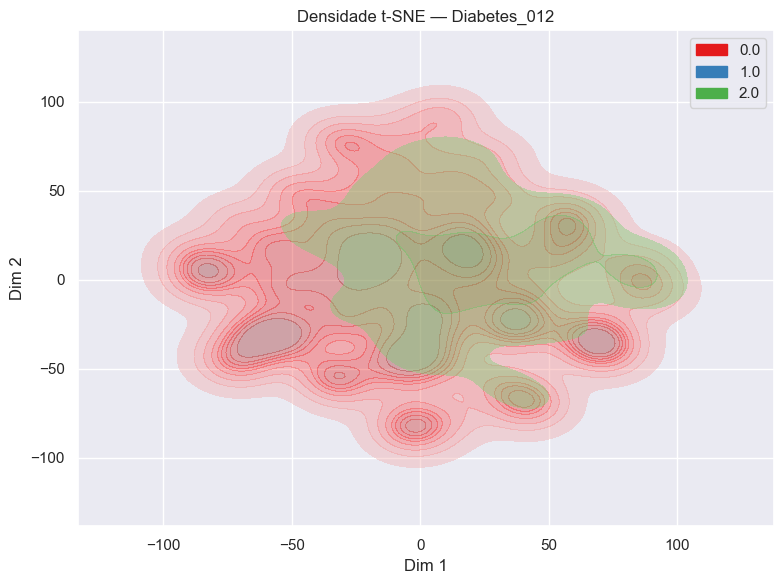

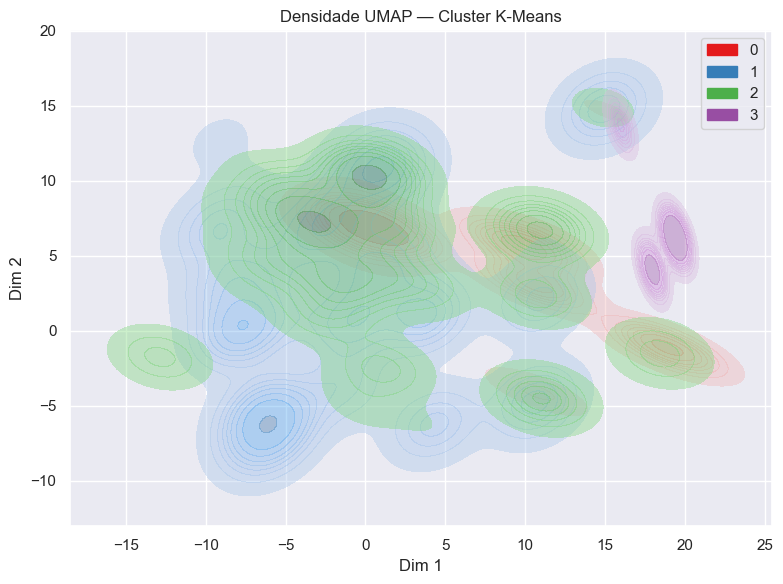

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density(X_embedded, labels, title):
    plt.figure(figsize=(8,6))
    sns.kdeplot(
        x=X_embedded[:,0],
        y=X_embedded[:,1],
        hue=labels,
        fill=True,
        alpha=0.4,
        palette="Set1"
    )
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

# Densidade por Diabetes
plot_density(X_tsne, y_sample, "Densidade t-SNE — Diabetes_012")

# Densidade por Cluster K-Means
plot_density(X_umap, labels_k_sample, "Densidade UMAP — Cluster K-Means")


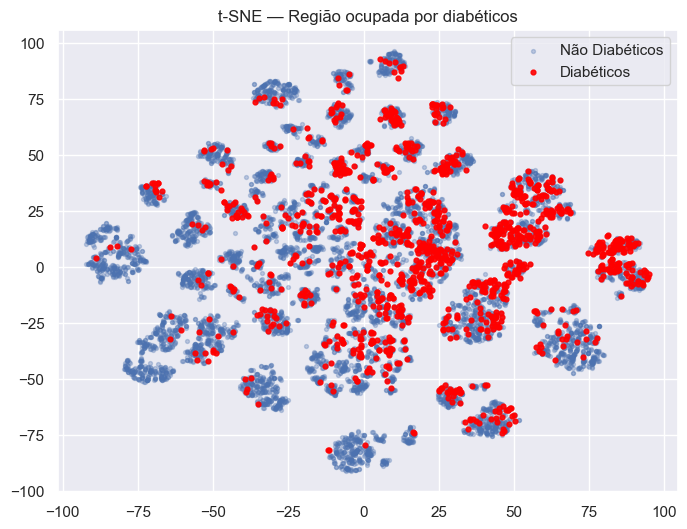

In [86]:
plt.figure(figsize=(8,6))

non_diab = y_sample != 2
diab = y_sample == 2

plt.scatter(X_tsne[non_diab,0], X_tsne[non_diab,1], s=8, alpha=0.3, label="Não Diabéticos")
plt.scatter(X_tsne[diab,0], X_tsne[diab,1], s=12, alpha=0.9, label="Diabéticos", color="red")

plt.title("t-SNE — Região ocupada por diabéticos")
plt.legend()
plt.grid(True)
plt.show()


In [87]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# import numpy as np

# tsne3 = TSNE(n_components=3, perplexity=30, random_state=42)
# X_tsne3 = tsne3.fit_transform(X_sample)

# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Cores consistentes para os clusters
# colors = plt.cm.tab10(np.unique(labels_k_sample))

# for cluster_id, color in zip(np.unique(labels_k_sample), colors):
#     mask = labels_k_sample == cluster_id
#     ax.scatter(
#         X_tsne3[mask, 0], X_tsne3[mask, 1], X_tsne3[mask, 2],
#         s=20, color=color, alpha=0.7, label=f"Cluster {cluster_id}"
#     )

# ax.set_title("t-SNE em 3D — Clusters K-Means")
# ax.legend(title="Clusters", loc="upper left")

# plt.show()



In [88]:
!pip install nbformat ipython



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [89]:
# import plotly.express as px
# from sklearn.manifold import TSNE

# # Rodar t-SNE em 3D
# tsne3 = TSNE(n_components=3, perplexity=30, random_state=42)
# X_tsne3 = tsne3.fit_transform(X_sample)

# # Criar DataFrame para facilitar
# import pandas as pd
# df_tsne3 = pd.DataFrame({
#     "x": X_tsne3[:, 0],
#     "y": X_tsne3[:, 1],
#     "z": X_tsne3[:, 2],
#     "cluster": labels_k_sample.astype(str)
# })

# # Plot 3D interativo
# fig = px.scatter_3d(
#     df_tsne3,
#     x="x", y="y", z="z",
#     color="cluster",
#     opacity=0.7,
#     title="t-SNE 3D Interativo — K-Means",
#     width=900,
#     height=700
# )

# fig.show()
# fig.write_html("tsne_3d_interativo.html")


### 8. Comparação numérica dos métodos (Silhouette)
Aqui juntamos os valores de silhouette de cada método para comparar:
- K-Means (full)
- Agglomerative (amostra)
- DBSCAN (amostra, sem ruído)



In [90]:
# def contar_clusters(labels):
#     return len(np.unique(labels))

# n_clusters_k_full = contar_clusters(labels_k_full)
# n_clusters_agg = contar_clusters(labels_agg)
# n_clusters_db = contar_clusters(labels_db)

# resumo_metodos = pd.DataFrame({
#     "Método": [
#         "K-Means (full, k=4)",
#         "Agglomerative (amostra, k=4)",
#         "DBSCAN (amostra)"
#     ],
#     "Silhouette": [
#         float(sil_k_full),
#         float(sil_agg),
#         float(sil_db) if not np.isnan(sil_db) else np.nan
#     ],
#     "Nº clusters (incl. ruído)": [
#         n_clusters_k_full,
#         n_clusters_agg,
#         n_clusters_db
#     ]
# })

# display(resumo_metodos)

# comparar_silhouette(resumo_metodos)
